In [6]:
import glob
import pickle
import tqdm
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'mathtext.default':  'regular' })

In [7]:
RESULTS_BASELINE_CACHE_FILE = Path("results_baseline_cache.pickle")
RESULTS_MONKEY_CACHE_FILE = Path("results_monkey_cache.pickle")
RESULTS_DROIDBOT_CACHE_FILE = Path("results_droidbot_cache.pickle")

TOOLS = {
        "baseline": 
            "../baseline/results_baseline-01/**/result.pickle",
        "monkey": 
            "../monkey/results_monkey-01/**/result.pickle",
        "droidbot": 
            "../droidbot/results_droidbot-01/**/result.pickle",
    }

def _uprobes_to_total_and_cumulative(hit_uprobes):
    toplot_unique = []
    toplot_total = []
    _known_offs = set()
    _total_probes = 0

    for _, ts, offs in hit_uprobes:
        _total_probes+=1
        if _total_probes % 50 == 1:
            # total number is a lot, so we batch it in 50s steps
            toplot_total.append((ts, _total_probes))
        if offs not in _known_offs:
            _known_offs.add(offs)
            toplot_unique.append((ts, len(_known_offs)))
    if len(toplot_total) > 0:
        tsses_total, total = zip(*toplot_total)
    else:
        tsses_total = []
        total = []
    if len(toplot_unique) > 0:
        tsses_cumulative, cumulative = zip(*toplot_unique)
    else:
        tsses_cumulative = []
        cumulative = []
    return tsses_total, total, tsses_cumulative, cumulative

def _get_num_tracepoints_set(offsets_info): #compare to _create_tracepoints_sh from Tracer class
    counter = 0
    _unique_offsets = set()
    for _,_, offset, _, computed_offset, _ in offsets_info:
        if int(offset, 16) == 0:
            continue
        if computed_offset in _unique_offsets:
            continue
        else:
            _unique_offsets.add(computed_offset)
        counter += 1
        if counter >= 20_000: # in makefile config for this run
            break
    return len(_unique_offsets)

def read_all_results(resglob):
    all_tsses = []
    all_cumulative_total = []
    all_cumulative_relative = []
    all_total = []
    all_appids = []
    for resfile in tqdm.tqdm(glob.glob(resglob)):
        apkid = str(resfile).split('/')[-2]
        #print(apkid)
        with open(resfile, 'rb') as f:
            profile_info, offsets_info, trace_info, hit_uprobes = pickle.load(f)
        tsses_total, total, tsses_cumulative, cumulative = _uprobes_to_total_and_cumulative(hit_uprobes)
        num_tracepoints_set = len(trace_info)
        # add cumulative data
        all_tsses.extend(tsses_cumulative)
        all_cumulative_total.extend(cumulative)
        all_cumulative_relative.extend([float(c)/num_tracepoints_set for c in cumulative])
        all_appids.extend([apkid for _ in range(len(cumulative))])
        all_total.extend([pd.NA for _ in range(len(cumulative))])
        # add total data
        all_tsses.extend(tsses_total)
        all_total.extend(total)
        all_appids.extend([apkid for _ in range(len(total))])
        all_cumulative_total.extend([pd.NA for _ in range(len(total))])
        all_cumulative_relative.extend([pd.NA for _ in range(len(total))])
    
    df = pd.DataFrame({
            'seconds since first probe hit': all_tsses,
            'cumulative number of unique probes hit': all_cumulative_total,
            'profile coverage': all_cumulative_relative,
            'cumulative number of non-unique probes hit': all_total,
            'app id': all_appids
        })
    return df


def read_from_cache_or_generate_tool(cachepath, tool):
    if not cachepath.exists():
        print(f"no cache found, loading {tool} from raw data")
        results = read_all_results(TOOLS[tool])
        results.to_pickle(cachepath)
    else:
        print(f"loading {tool} from cache!")
        with open(cachepath) as f:
            results = pd.read_pickle(cachepath)
        print(f"loaded {tool} results for {results['app id'].nunique()} apps from cache!")
    return results


results_baseline = read_from_cache_or_generate_tool(RESULTS_BASELINE_CACHE_FILE, "baseline")
results_monkey = read_from_cache_or_generate_tool(RESULTS_MONKEY_CACHE_FILE, "monkey")
results_droidbot = read_from_cache_or_generate_tool(RESULTS_DROIDBOT_CACHE_FILE, "droidbot")



loading baseline from cache!
loaded baseline results for 77 apps from cache!
loading monkey from cache!
loaded monkey results for 44 apps from cache!
loading droidbot from cache!
loaded droidbot results for 76 apps from cache!


In [8]:
results_baseline[results_baseline['profile coverage'] > 1.0]['app id'].unique()
results_monkey[results_monkey['profile coverage'] > 1.0]['app id'].unique()
results_droidbot[results_droidbot['profile coverage'] > 1.0]['app id'].unique()

array([], dtype=object)

In [9]:
# see https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot

def lineplot_unique(results, title, ):
    ax = sns.lineplot(
            x='seconds since first probe hit',
            y='cumulative number of unique probes hit',
            hue='app id',
            data=results,
            legend=False)
    ax.set_title(title)
    ax.set(xlim=(0,600))
    plt.savefig(f"plots/profile-coverage_lineplot_unique_{title}.pdf")
    plt.show()

def lineplot_total(results, title, ystr='cumulative number of non-unique probes hit'):
    ax = sns.lineplot(
            x='seconds since first probe hit',
            y='cumulative number of non-unique probes hit',
            hue='app id',
            data=results,
            legend=False)
    ax.set_title(title)
    ax.set(xlim=(0,600))
    plt.yscale('log')
    plt.savefig(f"plots/profile-coverage_lineplot_total_{title}.pdf")
    plt.show()

def lineplot_relative(results, title):
    ax = sns.lineplot(
            x='seconds since first probe hit',
            y='profile coverage',
            hue='app id',
            data=results,
            legend=False)
    ax.set_title(title)
    ax.set(xlim=(0,600), ylim=(0,1))
    plt.savefig(f"plots/profile-coverage_lineplot_relative_{title}.pdf")
    plt.show()

# total unique

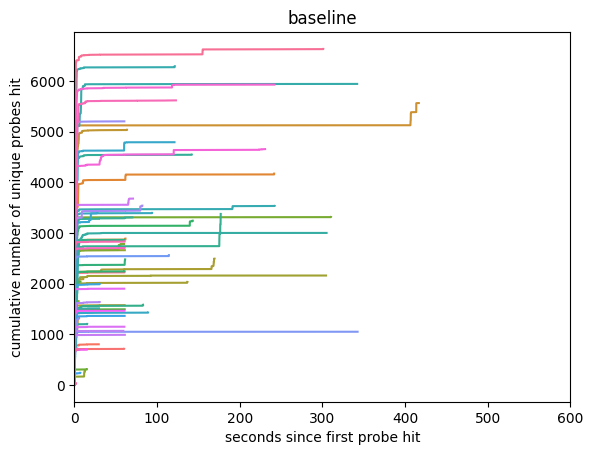

In [10]:
lineplot_unique(results_baseline, "baseline")

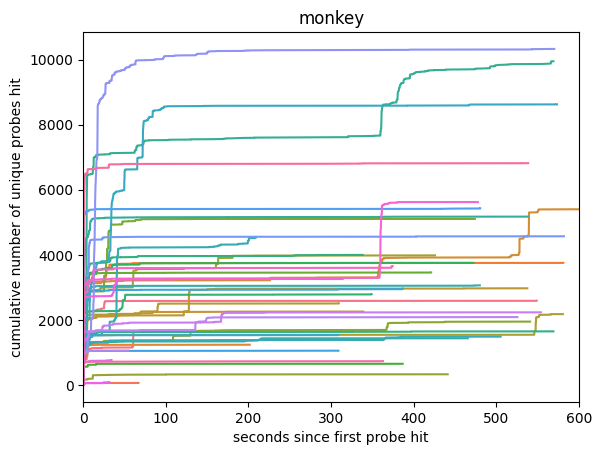

In [11]:
lineplot_unique(results_monkey, "monkey")

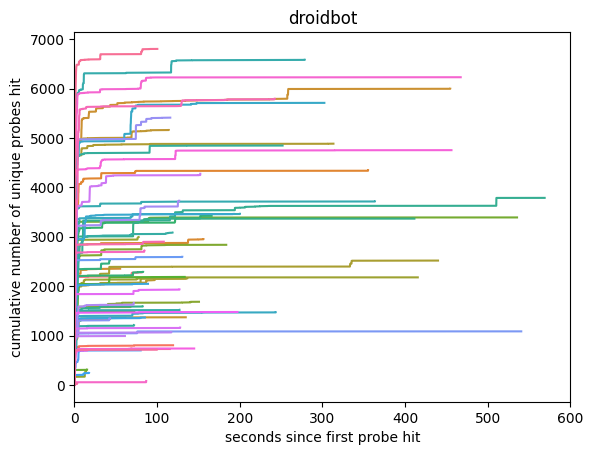

In [12]:
lineplot_unique(results_droidbot, "droidbot")

# total probes hit

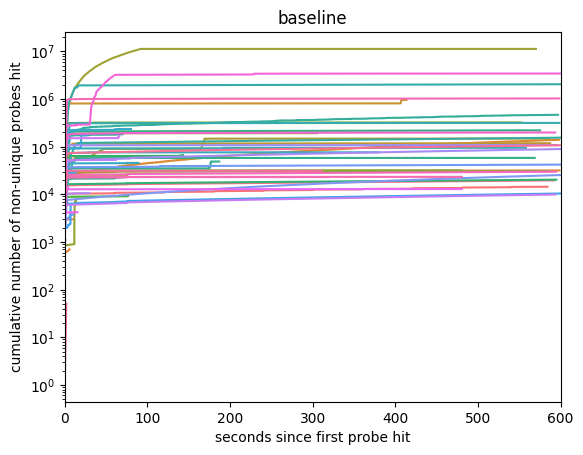

In [13]:
lineplot_total(results_baseline, "baseline")

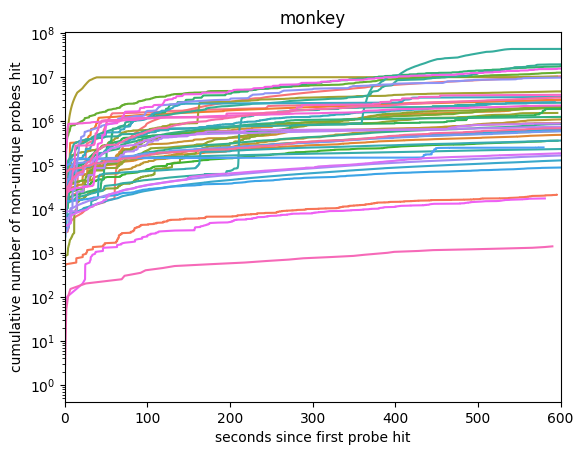

In [14]:
lineplot_total(results_monkey, "monkey")

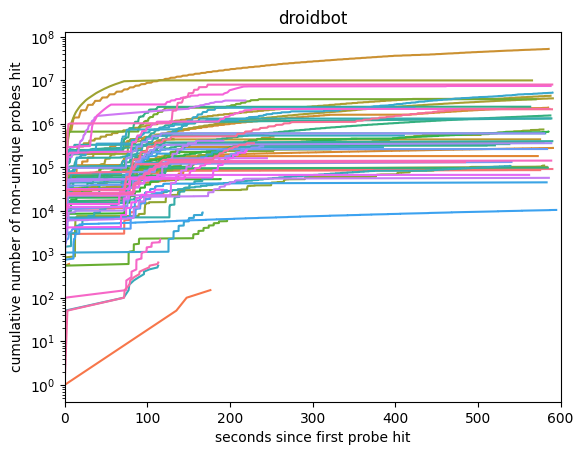

In [15]:
lineplot_total(results_droidbot, "droidbot")

# relative counts / profile coverage

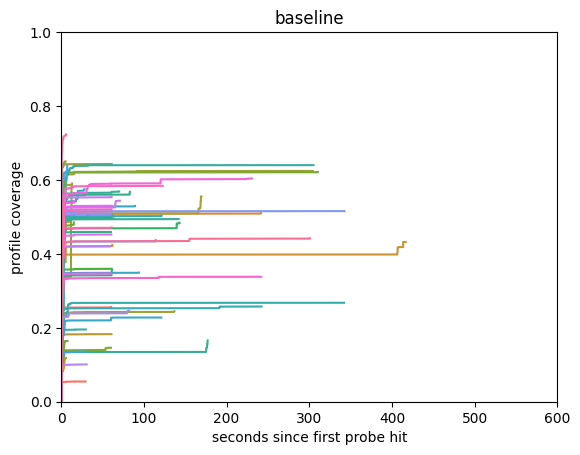

In [16]:
lineplot_relative(results_baseline, "baseline")

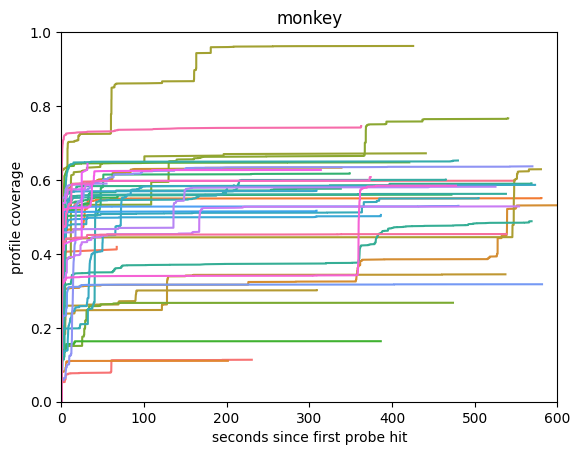

In [17]:
lineplot_relative(results_monkey, "monkey")

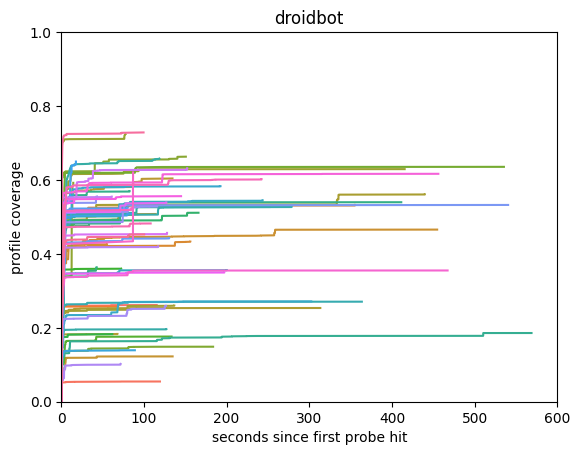

In [18]:
lineplot_relative(results_droidbot, "droidbot")

# comparative plots

In [19]:
def generate_boxplot_data():
    tools = []
    appids = []
    max_coverages = []
    _mc = results_baseline[['app id', 'profile coverage']].groupby('app id').max()
    max_coverages.extend(list(_mc['profile coverage']))
    appids.extend(list(_mc.index))
    tools.extend(['baseline' for _ in range(len(_mc))])

    _mc = results_monkey[['app id', 'profile coverage']].groupby('app id').max()
    max_coverages.extend(list(_mc['profile coverage']))
    appids.extend(list(_mc.index))
    tools.extend(['monkey' for _ in range(len(_mc))])
    
    _mc =results_droidbot[['app id', 'profile coverage']].groupby('app id').max()
    max_coverages.extend(list(_mc['profile coverage']))
    appids.extend(list(_mc.index))
    tools.extend(['droidbot' for _ in range(len(_mc))])
    
    return pd.DataFrame({'tool': tools, 'max coverage': max_coverages, "app id": appids})

max_coverage = generate_boxplot_data()

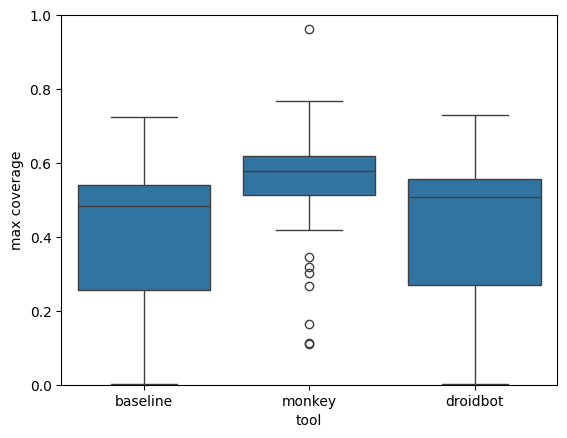

In [20]:
def draw_boxplot():
    ax = sns.boxplot(x='tool', y='max coverage', data=max_coverage)
    ax.set(ylim=(0,1))
    plt.savefig("plots/profile-coverage_boxplot.pdf")
    plt.show()

draw_boxplot()

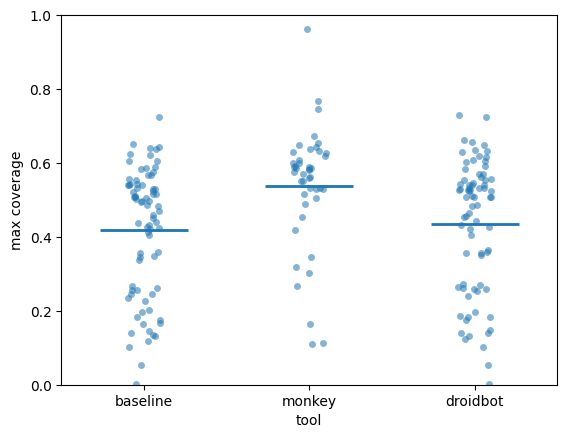

In [21]:
def draw_stripplot():
    # see https://seaborn.pydata.org/examples/jitter_stripplot.html

    #sns.set_theme(style="whitegrid")
    #iris = sns.load_dataset("iris")

    # "Melt" the dataset to "long-form" or "tidy" representation
    #iris = iris.melt(id_vars="species", var_name="measurement")

    # Initialize the figure
    f, ax = plt.subplots()
    #sns.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sns.stripplot(
        data=max_coverage, x="tool", y="max coverage", 
        #hue="tool",
        dodge=True, alpha=.55, zorder=1, legend=False,
    )
    ax.set(ylim=(0,1))

    # Show the conditional means, aligning each pointplot in the
    # center of the strips by adjusting the width allotted to each
    # category (.8 by default) by the number of hue levels
    sns.pointplot(
        data=max_coverage, x="tool", y="max coverage", 
        #hue="tool",
        #dodge=.3 - .3 / 3,
        #palette="dark", 
        errorbar=None,
        markers="_", markersize=64, linestyle="none",
    )

    # Improve the legend
    #sns.move_legend(
    #    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0,
    #)
    plt.savefig("plots/profile-coverage_stripplot.pdf")
    plt.show()

draw_stripplot()

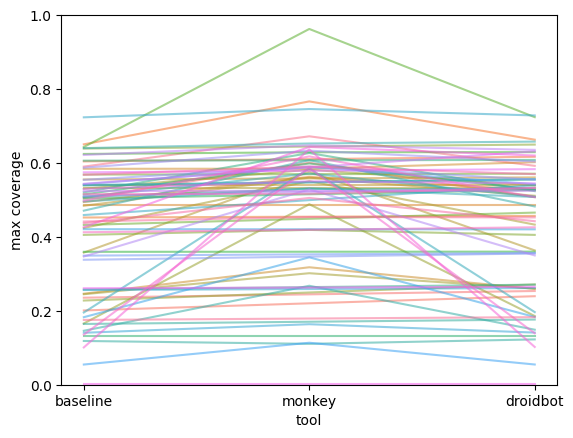

In [22]:
def draw_parallelplot():
    ax = sns.lineplot(data=max_coverage,
                            y="max coverage",
                            x= "tool",
                            hue="app id",
                            dashes=False,
                            markers=True,
                            markersize=8,
                            alpha=0.55,
                            legend=False)
    ax.set(ylim=(0,1))
    plt.savefig("plots/profile-coverage_parallelplot.pdf")
    plt.show()

draw_parallelplot()

In [23]:
max_coverage[max_coverage["max coverage"] > 0.9]

,tool,max coverage,app id
91,monkey,0.962533,com.google.android.videos


In [24]:
max_coverage[max_coverage["max coverage"] < 0.1]

,tool,max coverage,app id
52,baseline,0.054637,com.sega.sonicdash
66,baseline,0.002191,com.xvideostudio.videoeditor
172,droidbot,0.054705,com.sega.sonicdash
186,droidbot,0.002191,com.xvideostudio.videoeditor
